In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
!ls ./kaggle/working

ships32


## Exploration, Analyse, Data Preprocessing

In [11]:
directory = "./kaggle/working/ships32"
batch_size = 64
img_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="validation",
)


Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Found 48330 files belonging to 13 classes.
Using 9666 files for validation.


2025-04-14 19:25:26.225380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


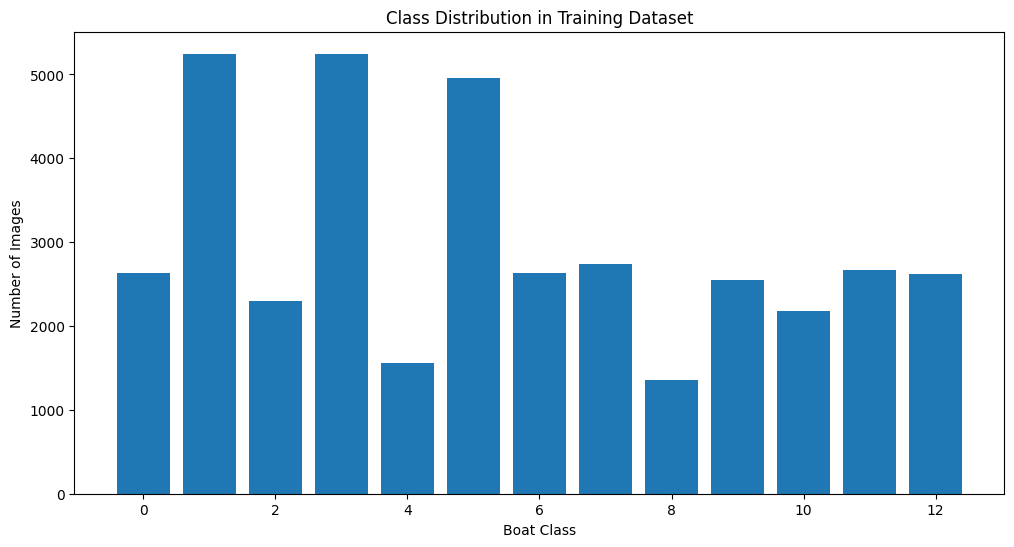

In [12]:
class_counts = {}
for image, label in train_ds.unbatch():
    label_val = label.numpy()  # Get the actual label value
    if label_val in class_counts:
        class_counts[label_val] += 1
    else:
        class_counts[label_val] = 1

# Plot class distribution
plt.figure(figsize=(12, 6))
classes = list(class_counts.keys())
counts = list(class_counts.values())
plt.bar(classes, counts)
plt.xlabel("Boat Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.show()

## Model

In [24]:
def BoatNet_30(input_shape=(32, 32, 3), num_classes=13):
    inputs = keras.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # First block with residual connection
    skip1 = x
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.add([x, skip1])
    x = layers.MaxPooling2D((2, 2))(x)

    # Second block with residual connection
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    skip2 = x
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, skip2])
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Final features
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Classification head
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [25]:
model = BoatNet_30()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("Nombre de couches : ", len(model.layers))

Nombre de couches :  24


In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,  # Reduce LR by factor of 0.2
    patience=3,  # Wait 3 epochs with no improvement
    min_lr=1e-6,
    verbose=1,
)

epochs = 30

# Then use in fit:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[reduce_lr])

## Résultat à soumettre

In [ ]:
X_test = np.load("/kaggle/input/navires-2025/ships_competition.npz", allow_pickle=True)[
    "X"
]
X_test = X_test.astype("float32") / 255


In [ ]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category": res})
df.to_csv("reco_nav.csv", index_label="Id")


In [ ]:
!head reco_nav.csv


In [ ]:
import os

os.chdir(r"/kaggle/working")
from IPython.display import FileLink

FileLink(r"reco_nav.csv")
